In [ ]:
import gym
import random
import os
import numpy as np
from collections      import deque
from keras.models     import Sequential, clone_model
from keras.layers     import Dense, Convolution2D, Flatten
from keras.optimizers import adam_v2
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import json
from copy import deepcopy
from time import sleep
from google.colab import files

In [ ]:
import tensorflow as tf
# if gpu is to be used
tf.config.list_physical_devices('GPU')

[]

In [ ]:
class Agent():
    def __init__(self, state_size, action_size, cold_start=True, episode_goal=0, current_episode =0):
        self.weight_backup = "space_invaders_weight_batch_16_improved.h5"
        self.parameters_backup = "space_invaders_parameters_batch_16_improved.json"
        self.scores_backup = "scores_batch_16_improved.json"
            
        self.current_episode = current_episode
        self.goal_episode = current_episode + episode_goal
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.learning_rate = 0.001
        self.gamma = 0.95
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = 0.95

        self.current_network = self._build_model()
        if not cold_start:
            net_to_load = "episode_goal_"+ str(current_episode) +"_" + self.weight_backup
            parameters_to_load = "episode_goal_"+ str(current_episode) +"_" + self.parameters_backup
            if os.path.isfile(net_to_load):
                self.load_model(net_to_load)
                # Trebalo bi sacuvati epsilon prilikom cuvanja modela kako bi mogli
                # da rekonstruisemo epsilon prilikom ucitavanja modela i nastavaka obucavanja.
                # Radi jednostavnosti, ovde cemo prosto pretpostaviti da model naucen
                # tako da ima smisla postaviti epsilon na minimalno dopustenu vrednost
                # (koju smo mi definisali prethodno).
                # Trebalo bi dakle:
                # self.exploration_rate = load_epsilon_from_file('train_info.json') ili nesto slicno
                # Ali mi cemo postaviti self.exploration_min
                self.load_parameters(parameters_to_load)
            else:
                print("Nema mreze!")

        self.target_network = clone_model(self.current_network)

    def _build_model(self):
        """Builds a neural network for DQN to use."""
        model = Sequential()
        model.add(Convolution2D(32, 9, strides=2, activation='relu',
                         input_shape=self.state_size, data_format="channels_last"))
        model.add(Convolution2D(24, 7, strides=2, activation='relu'))
        model.add(Convolution2D(16, 5, strides=2, activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=adam_v2.Adam(learning_rate=self.learning_rate))
        
        print(model.summary())
        
        return model

    def save_model(self, scores):
        """Saves the model weights to the path set in the object."""
        net_to_save = "episode_goal_"+ str(self.current_episode) +"_" + self.weight_backup
        self.current_network.save(net_to_save)

        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

        self.save_parameters()
        self.target_network = clone_model(self.current_network)
        self.save_scores(scores)
        sleep(5)
        files.download("episode_goal_"+ str(self.current_episode) +"_" + self.weight_backup)
        files.download("episode_goal_"+ str(self.current_episode) +"_" + self.parameters_backup)
        files.download("episode_goal_"+ str(self.current_episode) +"_" + self.scores_backup)

    def load_model(self, net_to_load):
        """LOads the model weights from the path set in the object."""
        self.current_network.load_weights(net_to_load)

    def save_parameters(self):
        fajl = {}
        fajl["exploration_rate"] = self.exploration_rate
        fajl["exploration_decay"] = self.exploration_decay
        fajl["exploration_min"] = self.exploration_min
        fajl["gamma"] = self.gamma

        parameters_to_save = "episode_goal_"+ str(self.current_episode) +"_" + self.parameters_backup

        with open(parameters_to_save, "w") as f:
            json.dump(fajl, f)
          
    def load_parameters(self, parameters_to_load):
        with open(parameters_to_load, "r") as f:
            fajl = json.load(f)

        self.exploration_rate = fajl["exploration_rate"]
        self.exploration_decay = fajl["exploration_decay"]
        self.exploration_min = fajl["exploration_min"]
        self.gamma = fajl["gamma"]

    def save_scores(self, scores):
        scores_to_save = "episode_goal_"+ str(self.current_episode) +"_" + self.scores_backup
        with open(scores_to_save, "w") as f:
            json.dump(scores,f)

    def act(self, state):
        """Acts according to epsilon greedy policy."""
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.target_network.predict(state)
        return np.argmax(act_values[0])

    # Cuvamo iskustvo u memoriji
    def remember(self, state, action, reward, next_state, done):
        """Saves experience in memory."""
        self.memory.append((state, action, reward, next_state, done))

    # Ucimo na osnovu informacija u memoriji
    def learn(self, sample_batch_size):
        if len(self.memory) < sample_batch_size:
            return
        sample_batch = random.sample(self.memory, sample_batch_size)

        states =[]
        q_values = []

        for state, action, reward, next_state, done in sample_batch:

            next_state_prediction = self.target_network.predict(next_state)
            next_q_value = np.max(next_state_prediction)
            q = self.current_network.predict(state)

            target = reward
            if not done:
                target = reward + self.gamma * next_q_value
            #target_f = self.network.predict(state)
            q[0][action] = target

            states.append(state)
            q_values.append(q)

        states = np.reshape(states, (sample_batch_size, 100,80,3))
        q_values = np.reshape(q_values, (sample_batch_size, 6))

        self.current_network.fit(states, q_values, epochs=1, verbose=0, batch_size=sample_batch_size) #batch_size=sample_batch_size//4,

        # if self.exploration_rate > self.exploration_min:
        #     self.exploration_rate *= self.exploration_decay

        # if(update_target_network):
        #     self.save_model()
        #     self.save_parameters()
        #     self.target_network = clone_model(self.current_network)


In [ ]:
class SpaceInvaders:
    def __init__(self, continue_training=False, episodes_to_train = 100, current_episode=0):
        self.sample_batch_size = 128
        self.steps_frequency_train = 32
        self.episodes = episodes_to_train
        self.env = gym.make('SpaceInvaders-v4')#, render_mode="human")

        #self.state_size = self.env.observation_space.shape
        self.state_size = (100,80,3)
        self.action_size = self.env.action_space.n
        self.agent = Agent(self.state_size, self.action_size, cold_start= (not continue_training), current_episode= current_episode)
        self.scores = []

        if(continue_training):
            self.scores = self.load_scores()

    def load_model(self):
        self.agent.load_model()
        
    def preprocess_image(self, img):
        #print("Size of pure image: ", img.shape)
        img_prep = img[:200,:]
        #print("Size of cropped image: ", img_prep.shape)
        thumbnail_size = img_prep.shape
        thumbnail_size = (thumbnail_size[1]//2, thumbnail_size[0]//2)
        img_prep = Image.fromarray(img_prep)
        img_prep.thumbnail(thumbnail_size)
        img_prep = np.asarray(img_prep)
        #print("Size of thumbanil image: ", img_prep.shape)

        return img_prep
        
    def load_scores(self):
        scores_to_load = "episode_goal_"+ str(self.agent.current_episode) + "_" + self.agent.scores_backup
        with open(scores_to_load, "r") as f:
            scores_loaded = json.load(f)
        
        return scores_loaded
        
    def run_test(self):
        state = self.env.reset()

        #self.env.render()
        done = False
        score = 0

        index = 0
        while not done:
            state = self.preprocess_image(state)
            state = np.reshape(state, [1] + list(self.state_size))
            action = self.agent.act(state)
            next_state, reward, done, _ = self.env.step(action)
            score  += reward
            state = next_state
            index += 1
            #self.env.render()
        print(f'Score: {score}')
        self.env.close()
        return score

    def run_train(self):
        
        ispis = ""
        for index_episode in tqdm(range(self.episodes)):
            state = self.env.reset()
            state = self.preprocess_image(state)
            
            state = np.reshape(state, [1] + list(self.state_size))

            done = False
            index = 0
            lives = 3
            score = 0
            while not done:
                # Uglavnom ne zelimo render tokom obucavanja
                # jer drasticno usporava proces optimizacije.
                # self.env.render()

                # Pustamo agenta da uradi neku akciju.
                action = self.agent.act(state)

                # Azuriramo stanje okruzenja.
                next_state, reward, done, info = self.env.step(action)
                next_state = self.preprocess_image(next_state)
                score += reward
                if(info["lives"]<lives):
                    score -= 100
                    lives -= 1
                # Menjamo oblik vektora za stanje kako bi stanje kasnije
                # mogli da propustimo kroz mrezu. Setite se, mreza prihvata
                # podskup instanci kao prvu dimenziju, usled toga dodajemo
                # jedinicu na pocetak - jer je ovo jedna instanca.
                next_state = np.reshape(next_state, [1] + list(self.state_size))

                # Cuvamo iskustvo.
                self.agent.remember(state, action, reward, next_state, done)
                state = next_state
                index += 1

                if(index%self.steps_frequency_train==0):
                    self.agent.learn(self.sample_batch_size)


            self.agent.current_episode+=1
            # Ispis procesa obucavanja u konzoli.
            # SAVET IZ PRAKSE:
            # Nije lose povremeno ove informacije pisati u datoteku, ali treba biti
            # pazljiv da se to ne radi stalno - nema smisla stalno pristupati disku
            # radi upisa jedne linije. Predlog je pisati u datoteku na svakih k epizoda (npr. k=100).
            
            print(f'Episode {self.agent.current_episode}/{self.agent.goal_episode} ; Score: {score} ; Duzina epizode: {index}\n')
            # ispis +=f'Episode {index_episode+1}/{self.episodes} ; Score: {score} ; Duzina epizode: {index}\n'
            
            # # if(index_episode % 10 == 0):
            # #   print(ispis)
            #   ispis = ""

            # Belezimo nagradu koju je agent osvojio u epizodi.
            self.scores.append(score)

            # Pustamo agenta da uci.
            if((index_episode+1)%5 == 0):
                scores_to_store = deepcopy(self.scores)
                self.agent.save_model(scores_to_store)

            self.agent.learn(self.sample_batch_size)

            # Primer: Ima smisla zaustaviti proces obucavanja ranije.
            # Kako je maksimalna nagrada 500 u ovom okruzenju, ako nas
            # agent u poslednjih 10 epizoda prosecno osvoji nagradu blizu
            # maksimalnoj, reklo bi se da je optimizacioni proces blizu resenja,
            # pa ima smisla tada zaustaviti trening.
            # Ovo je prosta heuristika, postoje mnogo sofisticiraniji pristupi
            # vodjenja optimizacije. Imajte u vidu da je DQN i delom nestabilan
            # i ne mora nuzno da konvergira - setite se predavanja :)
            
            # if index_episode > 10:
            #     last_10 = scores[-10:]
            #     avg = sum(last_10) / 10
            #     if avg > 490:
            #         break

        
        # Kada se optimizacioni proces zavrsi, cuvamo tezine mreze.
        #scores_to_store = deepcopy(self.scores)
        #self.agent.save_model(scores_to_store)

        # Vracamo istoriju treninga.
        return self.scores

In [ ]:
game = SpaceInvaders(episodes_to_train=10,continue_training=True, current_episode=130)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 36, 32)        7808      
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 15, 24)        37656     
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 6, 16)          9616      
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               393728    
                                                                 
 dense_7 (Dense)             (None, 128)               65664     
                                                                 
 dense_8 (Dense)             (None, 6)                

In [ ]:
#!pip install gym[atari] gym[accept-rom-license]
#!pip install gym[accept-rom-license]

In [ ]:
game.run_train()

  0%|          | 0/10 [00:00<?, ?it/s]

Episode 131/130 ; Score: -165.0 ; Duzina epizode: 776



 10%|█         | 1/10 [05:38<50:46, 338.49s/it]

Episode 132/130 ; Score: -105.0 ; Duzina epizode: 801



 20%|██        | 2/10 [12:11<49:24, 370.57s/it]

Episode 133/130 ; Score: -60.0 ; Duzina epizode: 860



 30%|███       | 3/10 [19:00<45:15, 387.90s/it]

Episode 134/130 ; Score: -95.0 ; Duzina epizode: 825



 40%|████      | 4/10 [25:32<38:58, 389.70s/it]

Episode 135/130 ; Score: -190.0 ; Duzina epizode: 507



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 50%|█████     | 5/10 [29:39<28:12, 338.40s/it]

Episode 136/130 ; Score: -70.0 ; Duzina epizode: 844



 60%|██████    | 6/10 [37:18<25:17, 379.35s/it]

Episode 137/130 ; Score: -70.0 ; Duzina epizode: 1174



 70%|███████   | 7/10 [47:59<23:14, 464.88s/it]

Episode 138/130 ; Score: -135.0 ; Duzina epizode: 670



 80%|████████  | 8/10 [53:33<14:06, 423.21s/it]

Episode 139/130 ; Score: 20.0 ; Duzina epizode: 942



 90%|█████████ | 9/10 [1:01:18<07:16, 436.19s/it]

Episode 140/130 ; Score: -70.0 ; Duzina epizode: 1189



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 10/10 [1:11:34<00:00, 429.45s/it]


[20.0,
 -195.0,
 -35.0,
 -180.0,
 -235.0,
 -145.0,
 -210.0,
 -165.0,
 -190.0,
 -90.0,
 -115.0,
 -210.0,
 -265.0,
 -85.0,
 -250.0,
 -145.0,
 -135.0,
 -165.0,
 -125.0,
 -180.0,
 -90.0,
 -180.0,
 -120.0,
 -90.0,
 -120.0,
 -205.0,
 -175.0,
 -245.0,
 -110.0,
 -255.0,
 -145.0,
 140.0,
 -145.0,
 110.0,
 -90.0,
 -210.0,
 -270.0,
 -5.0,
 -260.0,
 -205.0,
 -200.0,
 -220.0,
 -130.0,
 10.0,
 45.0,
 -225.0,
 120.0,
 -125.0,
 -235.0,
 -45.0,
 -225.0,
 -285.0,
 -175.0,
 -285.0,
 -55.0,
 -145.0,
 -245.0,
 -190.0,
 -165.0,
 -145.0,
 -70.0,
 -190.0,
 -65.0,
 -90.0,
 185.0,
 -165.0,
 -120.0,
 -145.0,
 -180.0,
 -95.0,
 -150.0,
 -195.0,
 -90.0,
 140.0,
 -145.0,
 -115.0,
 -225.0,
 -50.0,
 -130.0,
 -170.0,
 -140.0,
 -205.0,
 30.0,
 25.0,
 -260.0,
 -90.0,
 -60.0,
 110.0,
 -145.0,
 -120.0,
 135.0,
 -180.0,
 -250.0,
 195.0,
 20.0,
 -130.0,
 -220.0,
 -10.0,
 -195.0,
 -200.0,
 -165.0,
 -120.0,
 -195.0,
 -120.0,
 -145.0,
 -60.0,
 -250.0,
 -245.0,
 -60.0,
 -150.0,
 -100.0,
 -260.0,
 -80.0,
 -145.0,
 135.0,
 -15.0,


In [ ]:

sleep(120)

In [ ]:
game = SpaceInvaders(episodes_to_train=10,continue_training=True, current_episode=90)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 46, 36, 32)        7808      
                                                                 
 conv2d_28 (Conv2D)          (None, 20, 15, 24)        37656     
                                                                 
 conv2d_29 (Conv2D)          (None, 8, 6, 16)          9616      
                                                                 
 flatten_9 (Flatten)         (None, 768)               0         
                                                                 
 dense_27 (Dense)            (None, 512)               393728    
                                                                 
 dense_28 (Dense)            (None, 128)               65664     
                                                                 
 dense_29 (Dense)            (None, 6)                

In [ ]:
game.run_train()

  0%|          | 0/10 [00:00<?, ?it/s]

Episode 91/90 ; Score: -55.0 ; Duzina epizode: 705



 10%|█         | 1/10 [04:07<37:05, 247.32s/it]

Episode 92/90 ; Score: -60.0 ; Duzina epizode: 873



 20%|██        | 2/10 [09:10<37:22, 280.36s/it]

Episode 93/90 ; Score: 325.0 ; Duzina epizode: 1315



 30%|███       | 3/10 [16:42<41:48, 358.42s/it]

Episode 94/90 ; Score: -140.0 ; Duzina epizode: 668



 40%|████      | 4/10 [20:32<30:46, 307.76s/it]

Episode 95/90 ; Score: -260.0 ; Duzina epizode: 345



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 50%|█████     | 5/10 [22:37<20:09, 241.89s/it]

Episode 96/90 ; Score: -165.0 ; Duzina epizode: 845



 60%|██████    | 6/10 [27:27<17:13, 258.46s/it]

Episode 97/90 ; Score: -100.0 ; Duzina epizode: 857



 70%|███████   | 7/10 [32:24<13:33, 271.06s/it]

Episode 98/90 ; Score: -90.0 ; Duzina epizode: 842



 80%|████████  | 8/10 [37:14<09:13, 276.88s/it]

Episode 99/90 ; Score: -195.0 ; Duzina epizode: 634



 90%|█████████ | 9/10 [40:52<04:18, 258.46s/it]

In [ ]:
scores = []

for i in range(20):
    scores.append(game.run_test())

Score: 150.0
Score: 15.0
Score: 275.0
Score: 145.0
Score: 140.0
Score: 105.0
Score: 130.0
Score: 110.0
Score: 110.0
Score: 300.0
Score: 325.0
Score: 110.0
Score: 60.0
Score: 20.0
Score: 260.0
Score: 90.0
Score: 110.0
Score: 145.0
Score: 350.0
Score: 60.0


In [ ]:
scores = [150, 15, 275, 145, 140, 105, 130, 110, 110, 300, 325, 110, 145, 350, 60]

In [ ]:
print(np.mean(scores))
print(np.std(scores))

164.66666666666666
96.34083015811912


(array([1., 1., 4., 4., 1., 0., 0., 1., 1., 2.]),
 array([ 15. ,  48.5,  82. , 115.5, 149. , 182.5, 216. , 249.5, 283. ,
        316.5, 350. ]),
 <a list of 10 Patch objects>)

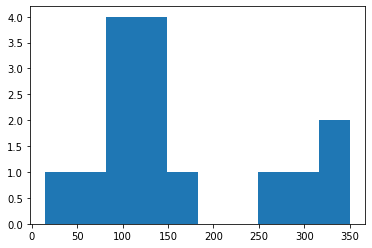

In [ ]:
plt.hist(scores)

In [ ]:
game.run_train()

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gym/utils/passive_env_checker.py:228: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  "Core environment is written in old step API which returns one bool instead of two. "


Episode 61/60 ; Score: -70.0 ; Duzina epizode: 696



  5%|▌         | 1/20 [04:02<1:16:42, 242.24s/it]

Episode 62/60 ; Score: -190.0 ; Duzina epizode: 675



 10%|█         | 2/20 [07:50<1:10:08, 233.82s/it]

Episode 63/60 ; Score: -65.0 ; Duzina epizode: 941



 15%|█▌        | 3/20 [13:02<1:16:23, 269.60s/it]

Episode 64/60 ; Score: -90.0 ; Duzina epizode: 894



 20%|██        | 4/20 [17:58<1:14:43, 280.21s/it]

Episode 65/60 ; Score: 185.0 ; Duzina epizode: 905



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 25%|██▌       | 5/20 [23:04<1:12:21, 289.41s/it]

Episode 66/60 ; Score: -165.0 ; Duzina epizode: 797



 30%|███       | 6/20 [27:30<1:05:38, 281.33s/it]

Episode 67/60 ; Score: -120.0 ; Duzina epizode: 929



 35%|███▌      | 7/20 [32:43<1:03:13, 291.78s/it]

Episode 68/60 ; Score: -145.0 ; Duzina epizode: 668



 40%|████      | 8/20 [36:25<53:55, 269.67s/it]  

Episode 69/60 ; Score: -180.0 ; Duzina epizode: 770



 45%|████▌     | 9/20 [40:44<48:49, 266.29s/it]

Episode 70/60 ; Score: -95.0 ; Duzina epizode: 858



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 50%|█████     | 10/20 [45:37<45:44, 274.50s/it]

Episode 71/60 ; Score: -150.0 ; Duzina epizode: 771



 55%|█████▌    | 11/20 [49:55<40:24, 269.37s/it]

Episode 72/60 ; Score: -195.0 ; Duzina epizode: 653



 60%|██████    | 12/20 [53:39<34:05, 255.73s/it]

Episode 73/60 ; Score: -90.0 ; Duzina epizode: 959



 65%|██████▌   | 13/20 [59:03<32:13, 276.21s/it]

Episode 74/60 ; Score: 140.0 ; Duzina epizode: 1002



 70%|███████   | 14/20 [1:04:43<29:32, 295.49s/it]

Episode 75/60 ; Score: -145.0 ; Duzina epizode: 795



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 75%|███████▌  | 15/20 [1:09:17<24:05, 289.05s/it]

Episode 76/60 ; Score: -115.0 ; Duzina epizode: 914



 80%|████████  | 16/20 [1:14:28<19:43, 295.79s/it]

Episode 77/60 ; Score: -225.0 ; Duzina epizode: 379



 85%|████████▌ | 17/20 [1:16:37<12:16, 245.48s/it]

Episode 78/60 ; Score: -50.0 ; Duzina epizode: 986



 90%|█████████ | 18/20 [1:22:11<09:04, 272.15s/it]

Episode 79/60 ; Score: -130.0 ; Duzina epizode: 754



 95%|█████████▌| 19/20 [1:26:28<04:27, 267.49s/it]

Episode 80/60 ; Score: -170.0 ; Duzina epizode: 965



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 20/20 [1:31:59<00:00, 275.97s/it]


[20.0,
 -195.0,
 -35.0,
 -180.0,
 -235.0,
 -145.0,
 -210.0,
 -165.0,
 -190.0,
 -90.0,
 -115.0,
 -210.0,
 -265.0,
 -85.0,
 -250.0,
 -145.0,
 -135.0,
 -165.0,
 -125.0,
 -180.0,
 -90.0,
 -180.0,
 -120.0,
 -90.0,
 -120.0,
 -205.0,
 -175.0,
 -245.0,
 -110.0,
 -255.0,
 -145.0,
 140.0,
 -145.0,
 110.0,
 -90.0,
 -210.0,
 -270.0,
 -5.0,
 -260.0,
 -205.0,
 -200.0,
 -220.0,
 -130.0,
 10.0,
 45.0,
 -225.0,
 120.0,
 -125.0,
 -235.0,
 -45.0,
 -225.0,
 -285.0,
 -175.0,
 -285.0,
 -55.0,
 -145.0,
 -245.0,
 -190.0,
 -165.0,
 -145.0,
 -70.0,
 -190.0,
 -65.0,
 -90.0,
 185.0,
 -165.0,
 -120.0,
 -145.0,
 -180.0,
 -95.0,
 -150.0,
 -195.0,
 -90.0,
 140.0,
 -145.0,
 -115.0,
 -225.0,
 -50.0,
 -130.0,
 -170.0]

In [ ]:
print("ej")

ej


In [ ]:
game = SpaceInvaders(episodes_to_train=10,continue_training=True, current_episode=30)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 46, 36, 32)        7808      
                                                                 
 conv2d_37 (Conv2D)          (None, 20, 15, 24)        37656     
                                                                 
 conv2d_38 (Conv2D)          (None, 8, 6, 16)          9616      
                                                                 
 flatten_12 (Flatten)        (None, 768)               0         
                                                                 
 dense_36 (Dense)            (None, 512)               393728    
                                                                 
 dense_37 (Dense)            (None, 128)               65664     
                                                                 
 dense_38 (Dense)            (None, 6)               

FileNotFoundError: ignored

In [ ]:
sleep(60)

In [ ]:
game.run_train()

In [ ]:
env = gym.make('SpaceInvaders-v4')#, new_step_api=True)#, render_mode="human")

In [ ]:
observation = env.reset()

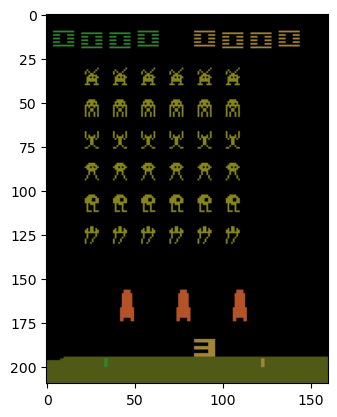

In [ ]:
plt.imshow(observation)

In [ ]:
from PIL import Image

In [ ]:
obs_prep = observation[:200,:]

In [ ]:
obs_prep = Image.fromarray(obs_prep)

In [ ]:
obs_prep.thumbnail(size = tuple(map(lambda x: x//2, obs_prep.size)))

In [ ]:
obs_prep.show()

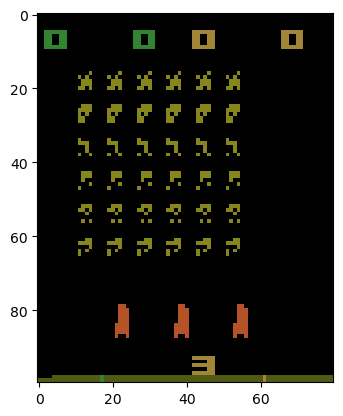

In [ ]:
plt.imshow(observation[:200:2,::2])

In [ ]:
from time import sleep

In [ ]:
for i in range(10000):
    akcija = random.randint(0,5)
    next_state, reward, done, info = env.step(akcija)
    if(info):
        print(info, "done: ", done)
        
    if(done):
        break
env.close()
